In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pystan

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

In [2]:
import pymc3 as pm
import theano
import theano.tensor as T
from scipy.stats.stats import pearsonr

In [3]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [4]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

To recap, variables of interest include: 

+ Echo parameters (LV systolic, RV size, pulmonary hypertension)
+ Fluids (day 1: missing term = 1 only if missing on day 1, day1-2: missing term = 1 if missing on day 1 or 2, day1-3: missing term = 1 if missing on day 1, day 2 or day 3)
+ Interactions: fluids x echo variables, fluids x CHF, echo x CHF
+ Covariates: Age, gender, BMI, BMI missing, mech vent, CHF, MDRD, Cr missing, apache score, lactate, lactate missing, ICU type, pressors indicator variable

Because of collinearity: 

+ Use only 1 fluid term per model
+ Use only 1 echo type variable per model
+ Use forward selection for interaction terms

In [5]:
query = """
SELECT * FROM icu_features
"""
ef = pd.read_sql_query(query, con)
ef.head()

,icustay_id,hadm_id,subject_id,age,gender,height,weight,ethnicity,insurance,filter_vaso,...,pc_bronch,pc_cath,pc_echo,pc_pressor,pc_rhc,pc_thora,pc_vent,passed_filters,use_record,bmi
0,200001,152234,55973,22290 days 19:06:12,F,167.851667,27.669135,ASIAN - ASIAN INDIAN,Medicare,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,9.820741
1,200003,163557,27513,17625 days 19:50:04,M,177.800000,78.224998,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,24.744692
2,200006,189514,10950,19736 days 11:28:14,M,165.100000,82.400002,OTHER,Medicaid,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.229647
3,200007,129310,20707,15818 days 10:03:37,M,177.800000,126.000000,WHITE,Private,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.857223
4,200009,129607,29904,17353 days 10:34:32,F,160.020000,85.833331,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,33.520264


In [6]:
len(ef)

61532

In [7]:
F = (ef['use_record'] == 1)

In [8]:
ef = ef.loc[F]
len(ef)

9320

# Preprocessing

## Calculate MDRD and add to feature table

In [9]:
def mdrd(data):
    creat = data.lab_creatinine
    age = data.age/np.timedelta64('1', 'Y')
    age.loc[age<0] = age.max()
    gender = data.gender.apply(lambda x: 0.742 if x == 'F' else 1)
    ethnicity = data.ethnicity.apply(lambda x: 1.212 if 'AFRICAN AMERICAN' in x else 1)
    return 175*creat**(-1.154) * age**(-0.203) * gender * ethnicity

In [10]:
value = mdrd(ef)
ef['mdrd'] = value
discrete = pd.cut(value, [0, 15, 30, 44, 60, 90, 1000000], labels=[5, 4, 3, 2, 1, 0], include_lowest=True)
ef['mdrd_discrete'] = discrete
discrete.value_counts()

0    2524
1    2068
2    1439
4    1280
3    1258
5     503
dtype: int64

In [11]:
discrete = pd.cut(value, [0, 30, 60, 1000000], labels=[2, 1, 0], include_lowest=True)
ef['mdrd_3'] = discrete
discrete.value_counts()

0    4592
1    2697
2    1783
dtype: int64

## Create general features table

In [12]:
def normalize(x):
    x = x.copy()
    I = ~np.isnan(x)
    x[I] = (x[I] - x[I].mean())/x[I].std()
    return x

In [13]:
X = pd.DataFrame()

# build the features table
age = ef.age/np.timedelta64('1', 'Y') # time in years
age_masked = age < 0 # if age is less than 0, then the person is above 89 (90?)
age = normalize(age)
age[age_masked] = 0
X['age'] = age
X['age_over_90'] = age_masked.astype(float)

gender = ef.gender
gender = (gender == 'F').astype(float)
X['gender'] = gender

bmi = ef.bmi
bmi_missing = np.isnan(bmi)
bmi = normalize(bmi)
bmi[bmi_missing] = 0
X['bmi'] = bmi
X['bmi_missing'] = bmi_missing.astype(float)

mech_vent = ef.vf_first_day_vent.astype(float)
X['mech_vent'] = mech_vent

chf = ef.ex_congestive_heart_failure.astype(float)
X['CHF'] = chf

mdrd = ef.mdrd
mdrd_missing = np.isnan(mdrd)
mdrd = normalize(mdrd)
mdrd[mdrd_missing] = 0
X['mdrd'] = mdrd

# MDRD missing is already largely covered by BMI missing
# the only other missing values come from missing creatinine lab
# so add that
creatinine_missing = np.isnan(ef.lab_creatinine)
X['creatinine_missing'] = creatinine_missing.astype(float)

apsiii = ef.apsiii
#apsiii_missing = np.isnan(apsiii)
apsiii = normalize(apsiii)
#apsiii[apsiii_missing] = 0
X['apsiii'] = apsiii
#X['apsiii_missing'] = apsiii_missing.astype(float)

no_echo = np.isnan(ef.ea_key)
#X['no_echo'] = no_echo.astype(float)

lvsys = ef.ea_lv_systolic
lv_missing = ((np.isnan(lvsys) | (lvsys < -1)) & ~no_echo).astype(float)
lv_normal = (lvsys == 0).astype(float)
lv_hyperdynamic = (lvsys == -1).astype(float)
lv_mild_depressed = (lvsys == 1).astype(float)
lv_mod_depressed = (lvsys == 2).astype(float)
lv_sev_depressed = (lvsys == 3).astype(float)
X['lv_missing'] = lv_missing
X['lv_normal'] = lv_normal
X['lv_hyper'] = lv_hyperdynamic
X['lv_mild'] = lv_mild_depressed
X['lv_moderate'] = lv_mod_depressed
X['lv_severe'] = lv_sev_depressed

tvpulm = ef.ea_tv_pulm_htn
tv_missing = ((np.isnan(tvpulm) | (tvpulm < -2)) & ~no_echo).astype(float)
tv_normal = (tvpulm == 0).astype(float)
tv_abnormal = ((tvpulm == -2) | (tvpulm > 0)).astype(float)
X['plm_htn_missing'] = tv_missing
X['plm_htn_normal'] = tv_normal
X['plm_htn_abnormal'] = tv_abnormal

rvcavity = ef.ea_rv_cavity
rvcav_missing = ((np.isnan(rvcavity) | (rvcavity < -2)) & ~no_echo).astype(float)
rvcav_normal = (rvcavity == 0).astype(float)
rvcav_small = (rvcavity == -1).astype(float)
rvcav_dilated = ((rvcavity == -2) | (rvcavity > 0)).astype(float)
X['rvcav_missing'] = rvcav_missing
X['rvcav_normal'] = rvcav_normal
X['rvcav_small'] = rvcav_small
X['rvcav_dilated'] = rvcav_dilated

lactate = ef.lab_lactate
lactate_missing = np.isnan(lactate)
lactate = normalize(lactate)
lactate[lactate_missing] = 0
X['lactate'] = lactate
X['lactate_missing'] = lactate_missing.astype(float)

## which ICU was treating the patient
sicu = ef.st_sicu.astype(float)
sicu[np.isnan(sicu)] = 0
nsicu = ef.st_nsicu.astype(float)
nsicu[np.isnan(nsicu)] = 0
micu = ef.st_micu.astype(float)
micu[np.isnan(micu)] = 0
X['sicu'] = sicu
X['nsicu'] = nsicu
X['micu'] = micu

## on vasopressors
on_vaso = ef.filter_vaso.astype(float)
X['on_vaso'] = on_vaso

## fluids
fluid_day1 = ef.fb_day1_balance_ml.values
f1_missing = np.isnan(fluid_day1)
fluid_day1[~f1_missing] = normalize(fluid_day1[~f1_missing])
fluid_day1[f1_missing] = 0
X['fluid_day1'] = fluid_day1
X['fluid_day1_missing'] = f1_missing.astype(float)

fluid_day2 = ef.fb_day2_balance_ml.values
f2_missing = np.isnan(fluid_day1) | np.isnan(fluid_day2)
fluid_day2[~f2_missing] = normalize(fluid_day2[~f2_missing])
fluid_day2[f2_missing] = 0
X['fluid_day2'] = fluid_day2
X['fluid_day2_missing'] = f2_missing.astype(float)

fluid_day3 = ef.fb_day3_balance_ml.values
f3_missing = np.isnan(fluid_day1) | np.isnan(fluid_day2) | np.isnan(fluid_day3)
fluid_day3[~f3_missing] = normalize(fluid_day3[~f3_missing])
fluid_day3[f3_missing] = 0
X['fluid_day3'] = fluid_day3
X['fluid_day3_missing'] = f3_missing.astype(float)

y = (ef.dod - ef.intime) < np.timedelta64(30, 'D')

X.shape, y.shape

((9320, 35), (9320,))

In [14]:
echo_features = {
    'lv': ['lv_missing', 'lv_normal', 'lv_hyper', 'lv_mild', 'lv_moderate', 'lv_severe'], 
    'plm_htn': ['plm_htn_missing', 'plm_htn_normal', 'plm_htn_abnormal'], 
    'rvcav': ['rvcav_missing', 'rvcav_normal', 'rvcav_small', 'rvcav_dilated'], 
}
fluid_features = {
    'fluid_day1': ['fluid_day1', 'fluid_day1_missing'], 
    'fluid_day2': ['fluid_day2', 'fluid_day2_missing'], 
    'fluid_day3': ['fluid_day3', 'fluid_day3_missing'],
}
# Age, gender, BMI, BMI missing, mech vent, CHF, MDRD, Cr missing, apache score, lactate, 
#lactate missing, ICU type, pressors indicator variable
covariates = ['age', 'age_over_90', # age
    "gender", # gender
    "bmi", "bmi_missing", # bmi
    "mech_vent", # mech_vent
    "CHF", # CHF
    "mdrd", "creatinine_missing", # MDRD
    "apsiii", # apache score
    "lactate", "lactate_missing", # lactate
    "sicu", "nsicu", "micu", # icu type
    "on_vaso", # pressors indicator variable
]

Train fluid features x echo features models: 

Compare AUROC for each set. 

In [15]:
import sklearn.model_selection
import sklearn.linear_model
import sklearn.metrics

In [138]:
ytr, yte = sklearn.model_selection.train_test_split(y, stratify = y)

models = {}
scores = {}
coefs = {}

Xs = {}

Xc = X[covariates]
X_ = Xc.copy()
Xtr = X_.loc[ytr.index]
Xte = X_.loc[yte.index]

model = sklearn.linear_model.LogisticRegressionCV(penalty = 'l1', solver = 'liblinear')
model.fit(Xtr, ytr)

ypr = model.predict(Xte)
score = sklearn.metrics.roc_auc_score(yte, ypr)
print('null', 'null', score)

models[('null', 'null')] = model
scores[('null', 'null')] = model
coefs[('null', 'null')] = pd.Series(model.coef_[0], index = Xtr.columns)

def make_data(fluid_fs, echo_fs): 
    
        Xf = X[fluid_features[fluid_fs]]
        Xe = X[echo_features[echo_fs]]
        Xc = X[covariates]

        # Interactions: fluids x echo variables, fluids x CHF, echo x CHF
        # Fluids x echo variables
        Xfe = {}
        for cf in Xf.columns: 
            for ce in Xe.columns: 
                Xfe["{}*{}".format(cf, ce)] = Xf[cf]*Xe[ce]
        Xfe = pd.DataFrame(Xfe)

        # Fluids x CHF
        Xfc = {}
        for cf in Xf.columns:
            Xfc["{}*CHF".format(cf)] = Xf[cf] * Xc['CHF']
        Xfc = pd.DataFrame(Xfc)

        # Echo x CHF
        Xec = {}
        for ce in Xe.columns: 
            Xec["{}*CHF".format(ce)] = Xe[ce] * Xc['CHF']
        Xec = pd.DataFrame(Xec)
        
        return pd.concat([Xf, Xe, Xc, Xfe, Xfc, Xec], axis = 1)

for fluid_fs in fluid_features.keys(): 
    for echo_fs in echo_features.keys(): 
        
        X_ = make_data(fluid_fs, echo_fs)
        Xs[(fluid_fs, echo_fs)] = X_

        Xtr = X_.loc[ytr.index]
        Xte = X_.loc[yte.index]

        model = sklearn.linear_model.LogisticRegressionCV(penalty = 'l1', solver = 'liblinear')
        model.fit(Xtr, ytr)

        ypr = model.predict(Xte)
        score = sklearn.metrics.roc_auc_score(yte, ypr)
        print(fluid_fs, echo_fs, score)
        
        models[(fluid_fs, echo_fs)] = model
        scores[(fluid_fs, echo_fs)] = score
        coefs[(fluid_fs, echo_fs)] = pd.Series(model.coef_[0], index = Xtr.columns)

null null 0.642604534579
fluid_day3 rvcav 0.642770878432
fluid_day3 lv 0.643999088527
fluid_day3 plm_htn 0.649308419733
fluid_day2 rvcav 0.647913865786
fluid_day2 lv 0.649474763587
fluid_day2 plm_htn 0.647150507007
fluid_day1 rvcav 0.643832744674
fluid_day1 lv 0.644233792868
fluid_day1 plm_htn 0.63148228324


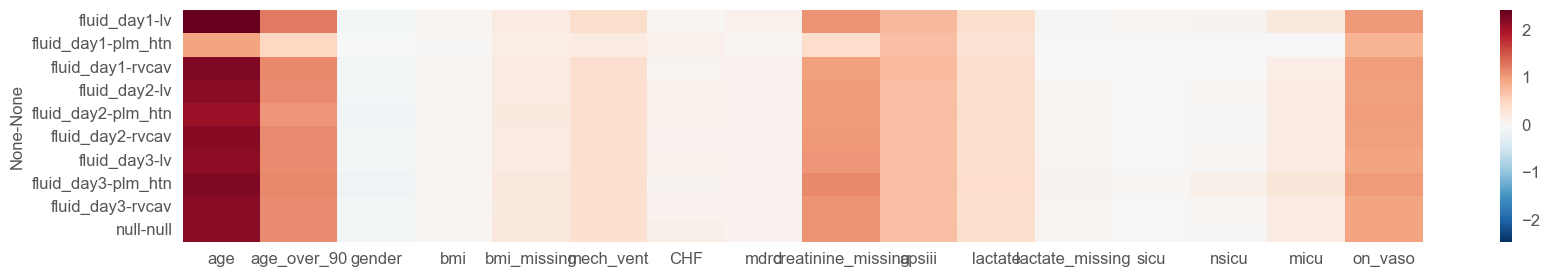

In [139]:
plt.figure(figsize = (20,3))
sns.heatmap(pd.concat(coefs).unstack()[covariates])

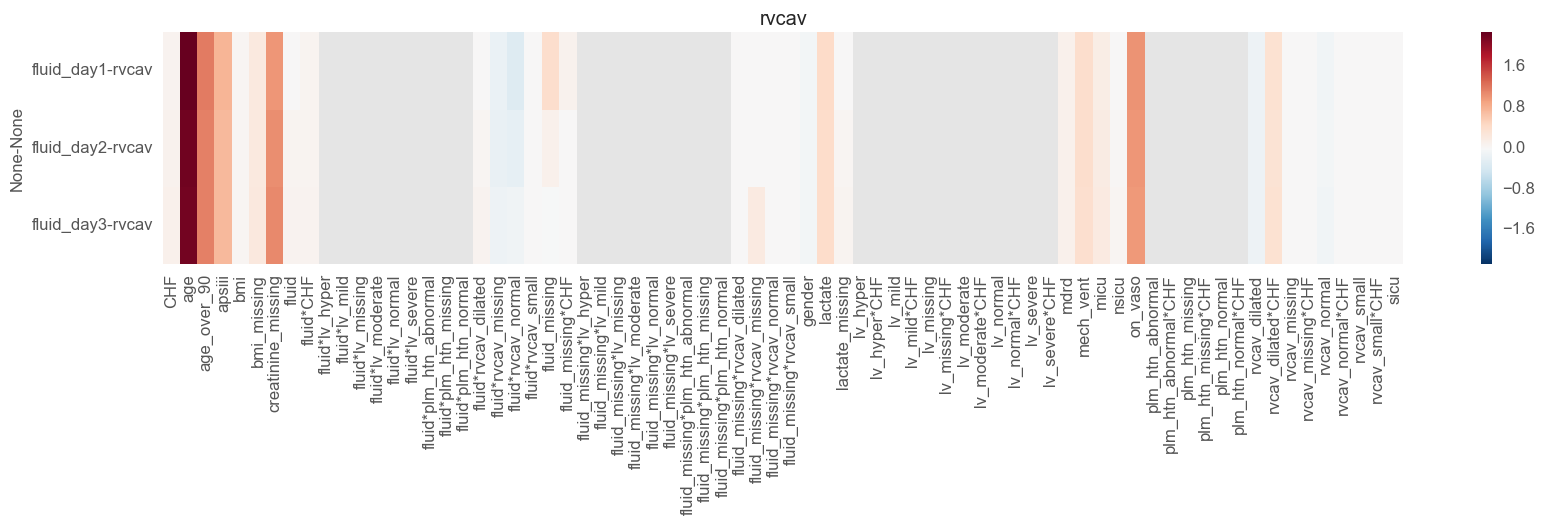

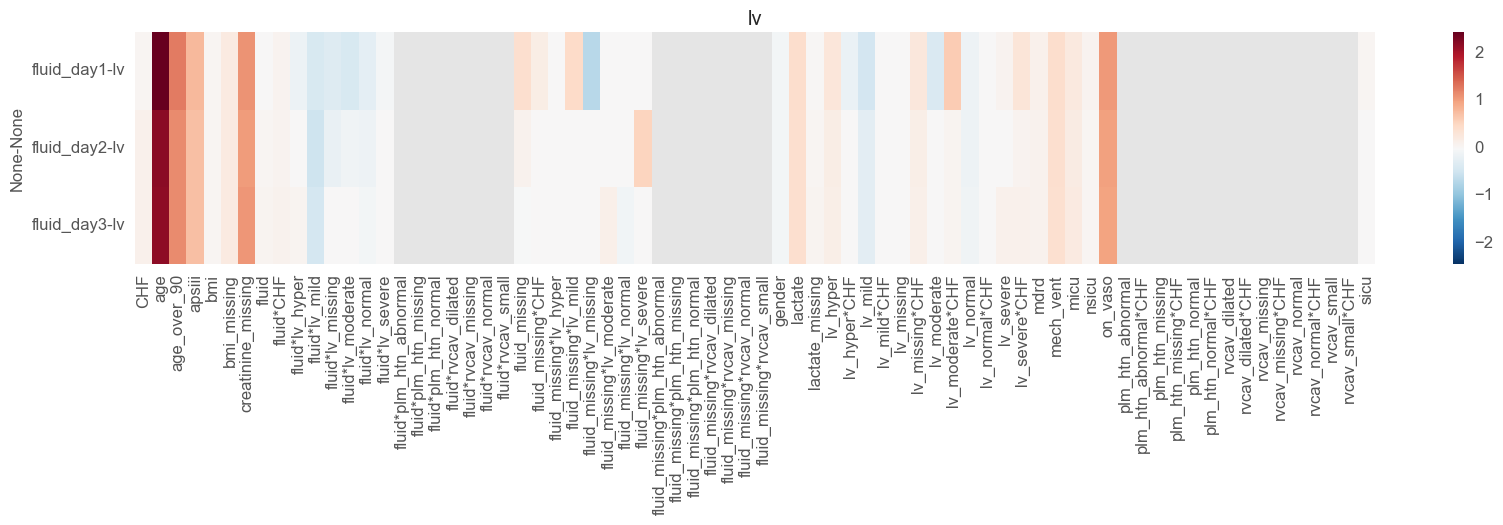

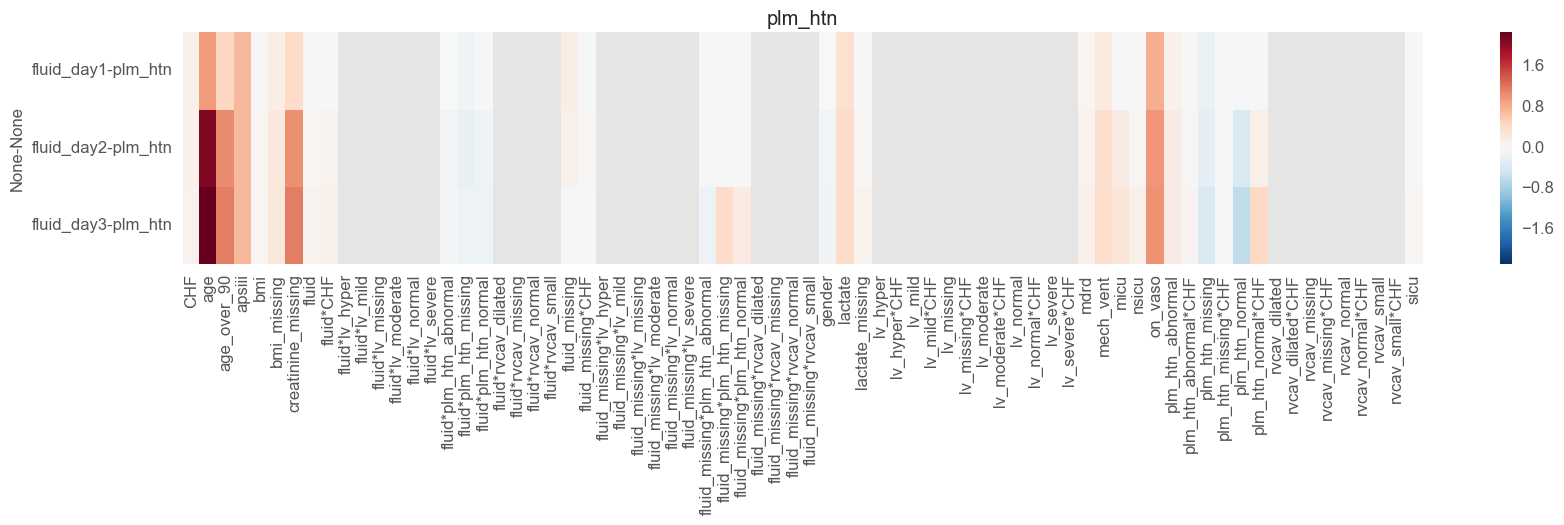

In [140]:
import copy

inspect = {}
it = copy.deepcopy(coefs)
for k, v in it.items():
    v.index = [c.replace(k[0], 'fluid') for c in v.index]
    inspect[k] = v
inspect = pd.DataFrame(inspect)

for echo_fs in echo_features.keys(): 

    to_plot = inspect.loc[:,(slice(None), echo_fs)]
    plt.figure(figsize = (20,3))
    sns.heatmap(to_plot.transpose())
    plt.title(echo_fs)

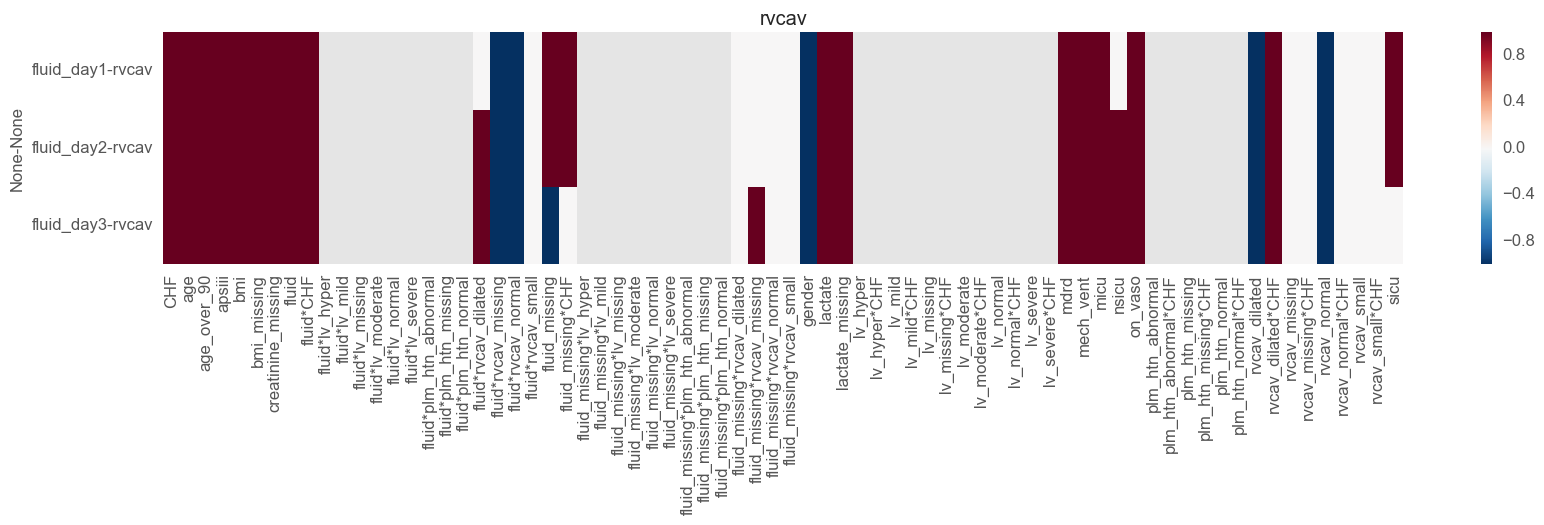

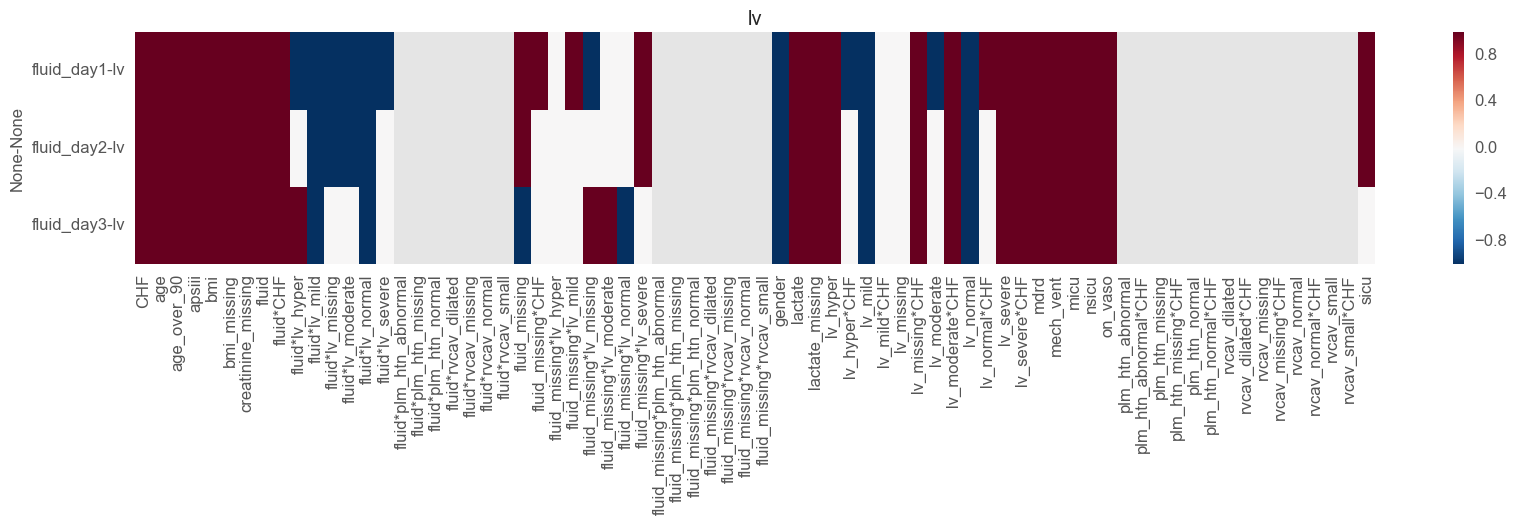

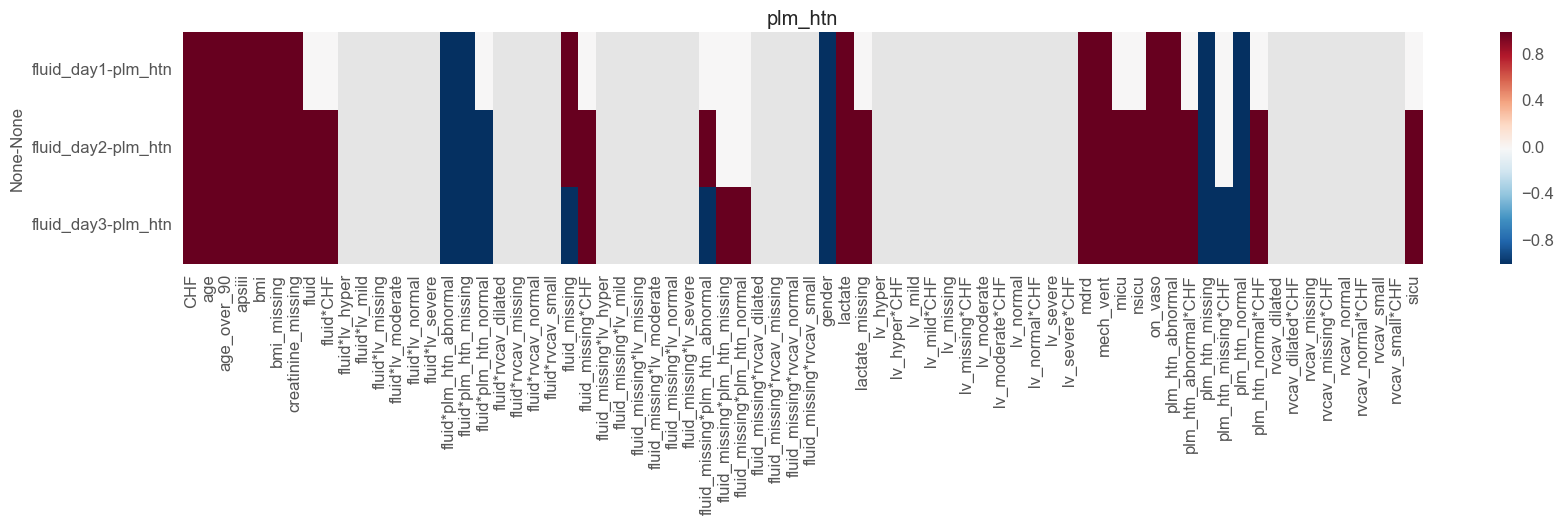

In [141]:
inspect = {}
it = copy.deepcopy(coefs)
for k, v in it.items():
    v.index = [c.replace(k[0], 'fluid') for c in v.index]
    inspect[k] = v
inspect = pd.DataFrame(inspect)

for echo_fs in echo_features.keys(): 

    to_plot = np.sign(inspect.loc[:,(slice(None), echo_fs)])
    
    plt.figure(figsize = (20,3))
    sns.heatmap(to_plot.transpose())
    plt.title(echo_fs)

In [99]:
import pymc3 as pm

In [100]:
def ridge(X, y, l=1.0):
    n = X.shape[1]
    beta = pm.Normal('beta', 0, l, shape=n)
    intercept = pm.Flat('intercept')
    
    # observation error
    sigma = pm.HalfCauchy('sigma', 5)
    
    yh = T.dot(X, beta) + intercept
    ydist = pm.Normal('y', mu=yh, sd=sigma, observed=y)

In [101]:
def logistic(X, y, l=1.0):
    n = X.shape[1]
    beta = pm.Normal('beta', 0, l, shape=n)
    intercept = pm.Flat('intercept')
    
    yh = T.nnet.sigmoid(T.dot(X, beta) + intercept)
    ydist = pm.Bernoulli('y', yh, observed=y)

## fluid_day1 x rvcav

(9320, 27)

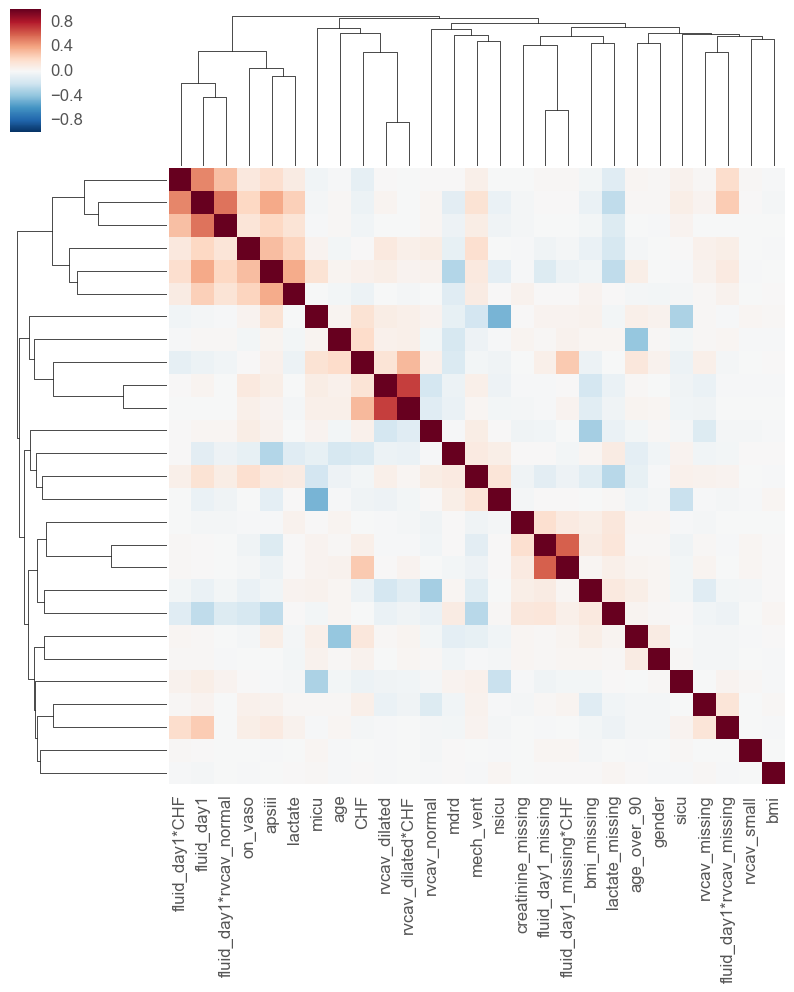

In [193]:
fluid_fs = 'fluid_day1'
echo_fs = 'rvcav'

Xb = Xs[(fluid_fs, echo_fs)].loc[:,(coefs[(fluid_fs, echo_fs)].abs() > 0) | 
    pd.Series(['*' not in c for c in coefs[(fluid_fs, echo_fs)].index], index = coefs[(fluid_fs, echo_fs)].index)]
sns.clustermap(Xb.corr(), yticklabels = False)
Xb.shape

In [194]:
with pm.Model() as model: 
    logistic(Xb, y)
    start = pm.find_MAP()
    step = pm.NUTS(scaling = start)
    trace = pm.sample(2000, step)

         Current function value: 4490.186957
         Iterations: 40
         Function evaluations: 106
         Gradient evaluations: 95


100%|██████████| 2000/2000 [05:58<00:00,  5.58it/s]


In [195]:
bayesian_coefs = pd.DataFrame(trace[200:]['beta'], columns = Xb.columns)
bayesian_coefs['intercept'] = trace[200:]['intercept']
bayesian_coefs.head()

,fluid_day1,fluid_day1_missing,rvcav_missing,rvcav_normal,rvcav_small,rvcav_dilated,age,age_over_90,gender,bmi,...,sicu,nsicu,micu,on_vaso,fluid_day1*rvcav_missing,fluid_day1*rvcav_normal,fluid_day1*CHF,fluid_day1_missing*CHF,rvcav_dilated*CHF,intercept
0,0.050315,0.546388,0.026865,-0.026741,-0.006498,-0.026028,2.213281,1.332317,-0.064451,0.050970,...,-0.075765,-0.030249,0.153457,1.028315,-0.235242,-0.360023,0.069746,0.185426,0.497979,-2.495931
1,-0.018524,0.465436,-0.013770,-0.128736,0.108906,-0.101203,2.386515,1.242095,-0.109854,0.066115,...,-0.019961,-0.025434,0.235496,1.012830,-0.115305,-0.254229,0.159998,0.190427,0.445254,-2.398095
2,0.084481,0.295796,0.043368,0.029299,0.110025,-0.130545,2.460744,1.345306,-0.071494,0.059542,...,-0.007475,0.129532,0.306210,0.949549,-0.248695,-0.390456,0.025720,0.132118,0.430458,-2.636667
3,0.045379,0.493461,0.005156,0.014736,0.249541,-0.073333,2.266371,1.120067,0.041196,0.076059,...,0.014109,-0.076621,0.191521,0.828417,-0.289310,-0.389910,0.056334,0.220559,0.273899,-2.437130
4,-0.066037,0.333387,0.304611,-0.072789,0.543419,-0.016062,2.071711,1.189605,-0.154191,0.059334,...,0.017637,-0.003524,0.229656,1.207113,-0.142324,-0.275801,0.186080,0.254916,0.306054,-2.354964


,age,age_over_90,gender,bmi,bmi_missing,mech_vent
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,2.346708,1.243857,-0.082519,0.060927,0.237404,0.386968
std,0.178365,0.109547,0.054705,0.028297,0.064724,0.057110
min,1.771603,0.895462,-0.241414,-0.036458,0.036309,0.192899
25%,2.230097,1.170721,-0.119185,0.042396,0.193336,0.349114
50%,2.345111,1.242780,-0.082394,0.059035,0.236074,0.388616
75%,2.460819,1.318210,-0.045392,0.079169,0.281354,0.426056
max,2.908552,1.601037,0.097143,0.194565,0.423689,0.546819


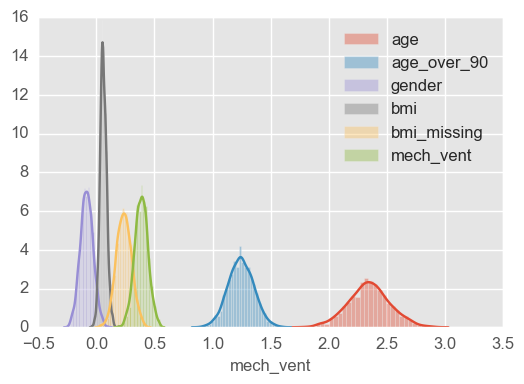

In [196]:
cols = covariates[:6]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,CHF,mdrd,creatinine_missing,apsiii,lactate,lactate_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.014090,0.113852,1.168377,0.788428,0.444864,0.052112
std,0.068691,0.027785,0.159823,0.036076,0.047607,0.058886
min,-0.244486,0.007100,0.613223,0.662178,0.279983,-0.164981
25%,-0.062140,0.095389,1.066210,0.764945,0.412133,0.012787
50%,-0.013647,0.113729,1.171548,0.787566,0.444917,0.052100
75%,0.033348,0.133648,1.271626,0.812902,0.477801,0.090372
max,0.176713,0.198646,1.712549,0.894897,0.602300,0.254707


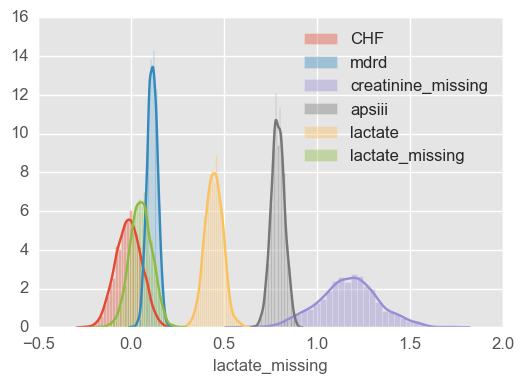

In [197]:
cols = covariates[6:12]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,sicu,nsicu,micu,on_vaso
count,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.010769,0.017206,0.243948,1.024932
std,0.059638,0.112094,0.080157,0.069274
min,-0.197085,-0.385319,-0.026809,0.801353
25%,-0.052411,-0.055462,0.188948,0.979585
50%,-0.011743,0.017664,0.241953,1.025095
75%,0.030050,0.090376,0.299489,1.071137
max,0.172780,0.417031,0.485755,1.258775


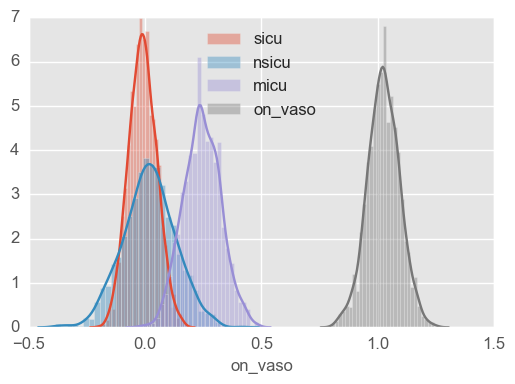

In [198]:
cols = covariates[12:]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,fluid_day1,fluid_day1_missing,rvcav_missing,rvcav_normal,rvcav_small,rvcav_dilated
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.028877,0.413446,0.081865,-0.047578,0.867028,-0.163469
std,0.038870,0.134938,0.119401,0.066968,0.608272,0.138941
min,-0.091205,-0.050987,-0.286343,-0.244962,-1.196373,-0.689716
25%,0.002668,0.321259,0.002428,-0.093560,0.470302,-0.262901
50%,0.028386,0.412330,0.082365,-0.045534,0.853800,-0.161826
75%,0.053832,0.503932,0.161284,-0.003853,1.253118,-0.067133
max,0.216100,0.876051,0.485597,0.164930,2.933486,0.287498


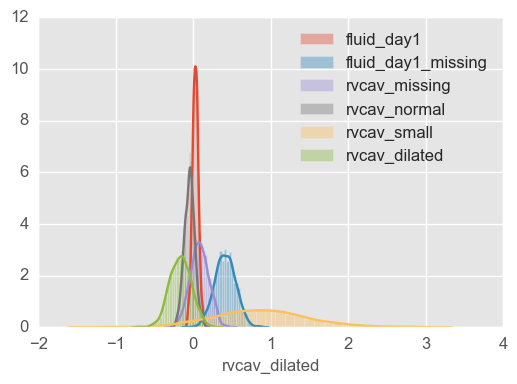

In [199]:
cols = fluid_features[fluid_fs] + echo_features[echo_fs]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,fluid_day1*rvcav_missing,fluid_day1*rvcav_normal
count,1800.000000,1800.000000
mean,-0.227265,-0.331038
std,0.107033,0.058926
min,-0.547659,-0.504614
25%,-0.296132,-0.371352
50%,-0.227940,-0.330094
75%,-0.156410,-0.291960
max,0.158484,-0.112593


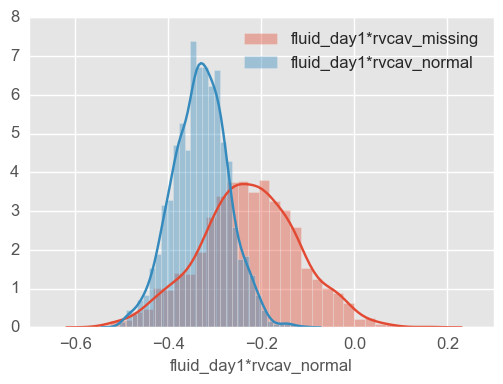

In [200]:
cols = [c for c in Xb.columns if 'fluid_day1*rvcav' in c]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,fluid_day1*CHF,fluid_day1_missing*CHF,rvcav_dilated*CHF
count,1800.000000,1800.000000,1800.000000
mean,0.093936,0.148122,0.397054
std,0.064919,0.212843,0.181927
min,-0.121642,-0.581272,-0.176657
25%,0.048946,0.010551,0.279778
50%,0.094358,0.156199,0.400325
75%,0.138031,0.291324,0.510438
max,0.307916,0.770847,0.994709


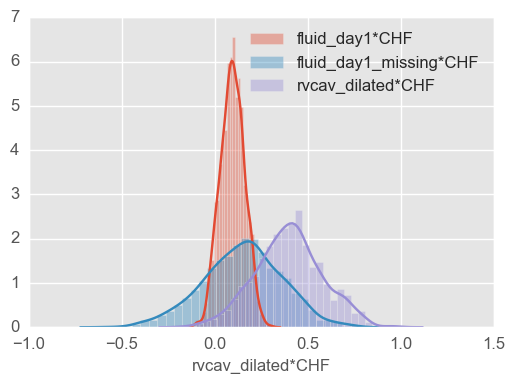

In [201]:
cols = [c for c in Xb.columns if '*CHF' in c]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

## fluid_day3 x rvcav

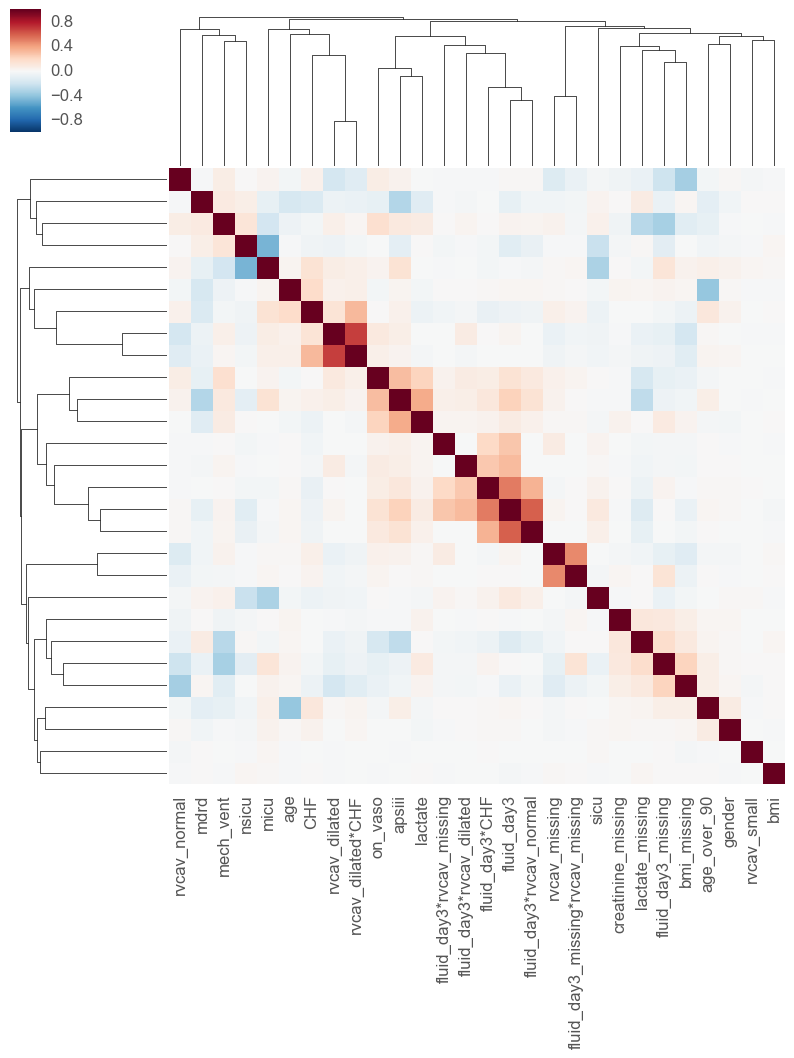

In [202]:
fluid_fs = 'fluid_day3'
echo_fs = 'rvcav'

Xb = Xs[(fluid_fs, echo_fs)].loc[:,(coefs[(fluid_fs, echo_fs)].abs() > 0) | 
    pd.Series(['*' not in c for c in coefs[(fluid_fs, echo_fs)].index], index = coefs[(fluid_fs, echo_fs)].index)]
sns.clustermap(Xb.corr(), yticklabels = False)

In [203]:
with pm.Model() as model: 
    logistic(Xb, y)
    start = pm.find_MAP()
    step = pm.NUTS(scaling = start)
    trace = pm.sample(2000, step)

         Current function value: 4512.020983
         Iterations: 39
         Function evaluations: 106
         Gradient evaluations: 95


100%|██████████| 2000/2000 [07:27<00:00,  4.47it/s]


In [204]:
bayesian_coefs = pd.DataFrame(trace[200:]['beta'], columns = Xb.columns)
bayesian_coefs['intercept'] = trace[200:]['intercept']
bayesian_coefs.head()

,fluid_day3,fluid_day3_missing,rvcav_missing,rvcav_normal,rvcav_small,rvcav_dilated,age,age_over_90,gender,bmi,...,nsicu,micu,on_vaso,fluid_day3*rvcav_dilated,fluid_day3*rvcav_missing,fluid_day3*rvcav_normal,fluid_day3_missing*rvcav_missing,fluid_day3*CHF,rvcav_dilated*CHF,intercept
0,0.145269,-0.010925,0.113198,0.000550,0.617850,-0.395861,2.514132,1.227765,-0.032846,0.094219,...,0.279289,0.471000,0.951022,-0.008314,-0.073570,-0.077807,0.131431,0.068013,0.768660,-2.710914
1,0.100726,-0.136542,0.115183,-0.168756,0.799839,-0.288470,2.615613,1.270116,-0.081138,0.061437,...,0.187662,0.372833,1.008162,0.084215,-0.191593,-0.103623,0.166873,0.009993,0.721646,-2.583283
2,0.115756,-0.089647,0.133866,-0.182095,0.752582,-0.278892,2.594468,1.234494,-0.086164,0.064812,...,0.196623,0.378342,1.019642,0.084176,-0.232526,-0.095169,0.214449,-0.018205,0.733830,-2.604062
3,0.046325,0.123217,-0.041689,0.051407,0.965098,-0.216787,2.569985,1.343563,-0.093978,0.102217,...,0.197401,0.394593,0.998897,0.027466,0.006674,-0.197403,0.370177,0.231621,0.227692,-2.697285
4,0.100380,-0.085571,-0.305431,-0.098400,0.894661,-0.062668,2.609000,1.315439,-0.072814,0.066162,...,0.109194,0.261771,1.147855,0.097370,-0.152770,-0.185424,0.460215,0.119087,0.418539,-2.635622


,age,age_over_90,gender,bmi,bmi_missing,mech_vent
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,2.295414,1.220183,-0.078696,0.061813,0.262020,0.369350
std,0.176507,0.109939,0.052847,0.028198,0.063899,0.059119
min,1.760435,0.827198,-0.235902,-0.023656,0.057086,0.158716
25%,2.182408,1.148929,-0.114332,0.042374,0.216849,0.328009
50%,2.298084,1.218335,-0.079725,0.061832,0.264442,0.368201
75%,2.416333,1.295784,-0.044977,0.080663,0.309130,0.409624
max,2.996707,1.552267,0.090353,0.161098,0.435106,0.586893


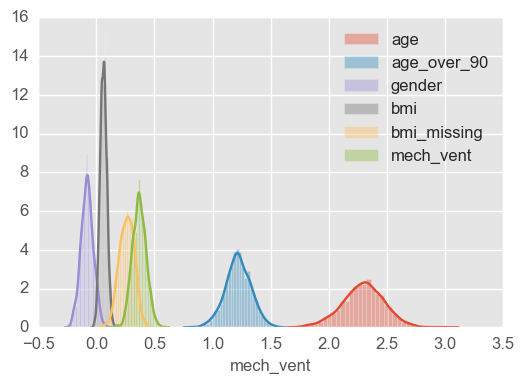

In [205]:
cols = covariates[:6]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,CHF,mdrd,creatinine_missing,apsiii,lactate,lactate_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.026347,0.114410,1.266919,0.742624,0.432544,0.091682
std,0.064448,0.028618,0.163473,0.034566,0.046997,0.061156
min,-0.176246,0.024199,0.844809,0.599256,0.249312,-0.127420
25%,-0.017629,0.094816,1.150219,0.721026,0.401722,0.051779
50%,0.028075,0.114957,1.265948,0.743491,0.432973,0.090611
75%,0.071879,0.134727,1.380302,0.764440,0.464304,0.131037
max,0.220350,0.199104,1.795416,0.874051,0.631951,0.308453


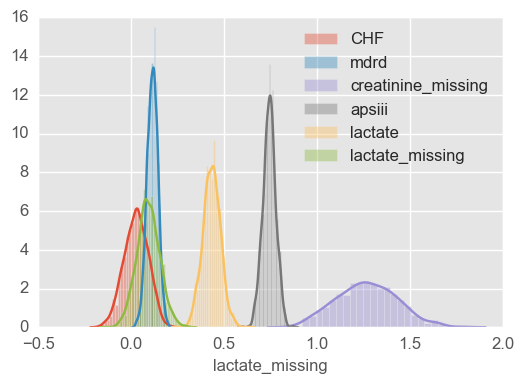

In [206]:
cols = covariates[6:12]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,sicu,nsicu,micu,on_vaso
count,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.020714,0.074389,0.280407,0.990562
std,0.063060,0.115258,0.081777,0.071262
min,-0.270586,-0.316564,-0.054716,0.707856
25%,-0.063755,-0.003106,0.230511,0.944889
50%,-0.020898,0.079122,0.279529,0.989725
75%,0.019407,0.148681,0.332429,1.039701
max,0.199617,0.442130,0.536871,1.213410


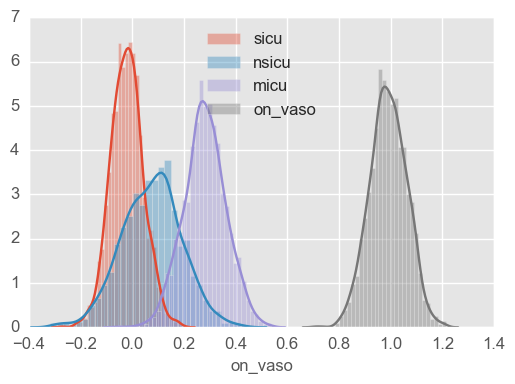

In [207]:
cols = covariates[12:]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,fluid_day3,fluid_day3_missing,rvcav_missing,rvcav_normal,rvcav_small,rvcav_dilated
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.119905,-0.005265,0.006754,-0.048407,0.950677,-0.149431
std,0.053240,0.061169,0.141175,0.068292,0.650147,0.144038
min,-0.062052,-0.195327,-0.524981,-0.256377,-0.905375,-0.591835
25%,0.082687,-0.044908,-0.086388,-0.094012,0.511383,-0.251704
50%,0.118583,-0.005686,0.012925,-0.047630,0.936662,-0.148658
75%,0.156273,0.037417,0.104839,-0.003115,1.410568,-0.053967
max,0.307763,0.214161,0.432747,0.150032,3.178880,0.359762


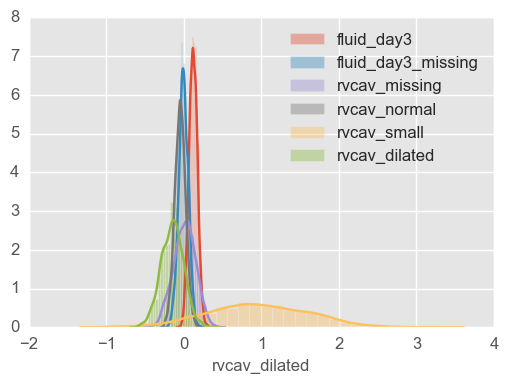

In [208]:
cols = fluid_features[fluid_fs] + echo_features[echo_fs]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,fluid_day3*rvcav_dilated,fluid_day3*rvcav_missing,fluid_day3*rvcav_normal
count,1800.000000,1800.000000,1800.000000
mean,0.014377,-0.167745,-0.170949
std,0.118954,0.124767,0.074162
min,-0.357618,-0.525529,-0.395123
25%,-0.062730,-0.250102,-0.220856
50%,0.009466,-0.164593,-0.170245
75%,0.092289,-0.088687,-0.121641
max,0.414685,0.224665,0.095039


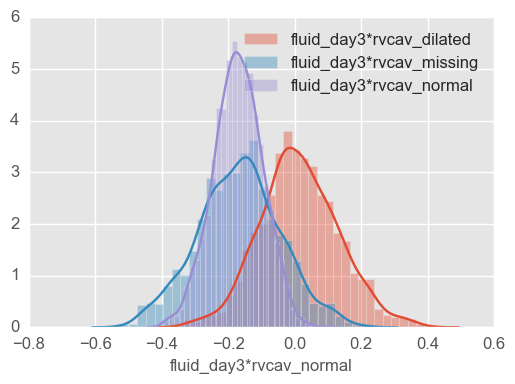

In [209]:
cols = [c for c in Xb.columns if 'fluid_day3*rvcav' in c]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,fluid_day3*CHF,rvcav_dilated*CHF
count,1800.000000,1800.000000
mean,0.103629,0.385205
std,0.075299,0.191384
min,-0.143080,-0.176822
25%,0.054650,0.255115
50%,0.104102,0.380626
75%,0.151438,0.517427
max,0.341042,0.951359


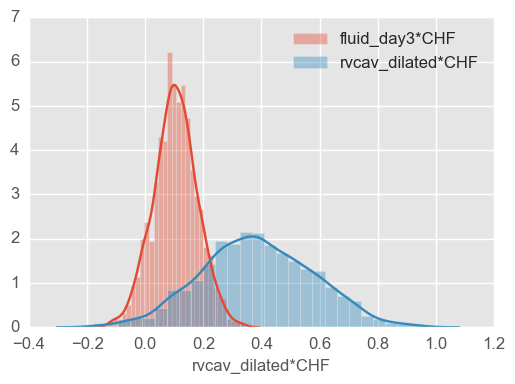

In [210]:
cols = [c for c in Xb.columns if '*CHF' in c]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

## fluid_day2 x lv

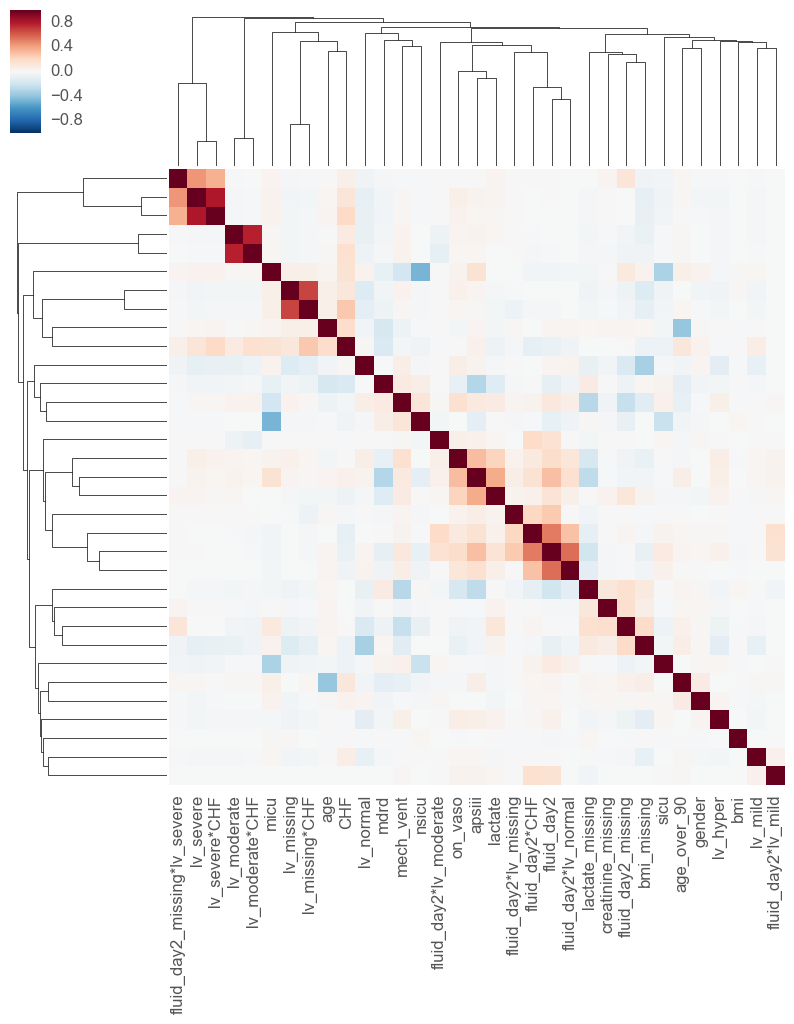

In [212]:
fluid_fs = 'fluid_day2'
echo_fs = 'lv'

Xb = Xs[(fluid_fs, echo_fs)].loc[:,(coefs[(fluid_fs, echo_fs)].abs() > 0) | 
    pd.Series(['*' not in c for c in coefs[(fluid_fs, echo_fs)].index], index = coefs[(fluid_fs, echo_fs)].index)]
sns.clustermap(Xb.corr(), yticklabels = False)

In [213]:
with pm.Model() as model: 
    logistic(Xb, y)
    start = pm.find_MAP()
    step = pm.NUTS(scaling = start)
    trace = pm.sample(2000, step)

Optimization terminated successfully.
         Current function value: 4504.813767
         Iterations: 44
         Function evaluations: 56
         Gradient evaluations: 56


100%|██████████| 2000/2000 [08:57<00:00,  9.00it/s]


In [214]:
bayesian_coefs = pd.DataFrame(trace[200:]['beta'], columns = Xb.columns)
bayesian_coefs['intercept'] = trace[200:]['intercept']
bayesian_coefs.head()

,fluid_day2,fluid_day2_missing,lv_missing,lv_normal,lv_hyper,lv_mild,lv_moderate,lv_severe,age,age_over_90,...,fluid_day2*lv_mild,fluid_day2*lv_missing,fluid_day2*lv_moderate,fluid_day2*lv_normal,fluid_day2_missing*lv_severe,fluid_day2*CHF,lv_missing*CHF,lv_moderate*CHF,lv_severe*CHF,intercept
0,0.068139,0.107342,0.085678,0.034596,0.167834,-0.199851,-0.338089,-0.260292,2.410404,1.371831,...,-0.225650,-0.433066,0.141841,-0.141635,0.697770,0.129464,0.303116,0.381426,0.251625,-2.504446
1,-0.017012,0.115050,-0.190205,0.014238,0.407089,-0.266142,-0.072575,-0.040568,2.240628,1.077257,...,-0.725166,0.030736,-0.324190,-0.084498,0.673041,0.196028,0.274578,0.689170,0.108493,-2.592898
2,0.116325,0.102193,0.076535,-0.033330,0.248076,-0.016636,-0.074222,-0.234784,2.188500,1.257645,...,-0.278508,-0.437133,-0.157059,-0.218053,0.770730,0.119940,0.465263,0.270182,0.214322,-2.440879
3,0.028480,0.122176,0.176875,-0.116997,0.374268,-0.268061,-0.133648,-0.015696,2.208544,1.249205,...,-0.590937,0.042612,-0.053387,-0.125826,0.736914,0.093461,-0.032872,0.000174,0.054566,-2.411921
4,-0.021347,0.174702,0.114628,0.056455,0.354622,-0.356434,-0.134319,-0.064355,2.166654,1.090912,...,-0.671525,-0.162477,-0.232637,-0.120966,0.754516,0.185816,0.237575,0.171875,-0.020334,-2.529036


,age,age_over_90,gender,bmi,bmi_missing,mech_vent
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,2.290396,1.210367,-0.080290,0.062306,0.246279,0.384979
std,0.185751,0.113148,0.051593,0.028685,0.060938,0.057348
min,1.529780,0.742423,-0.256376,-0.035321,0.034638,0.152829
25%,2.155503,1.136339,-0.114782,0.043440,0.205238,0.347444
50%,2.288479,1.211454,-0.079018,0.061145,0.245996,0.385060
75%,2.417855,1.286914,-0.044572,0.080252,0.287729,0.423746
max,2.894710,1.619395,0.096805,0.176017,0.464006,0.568321


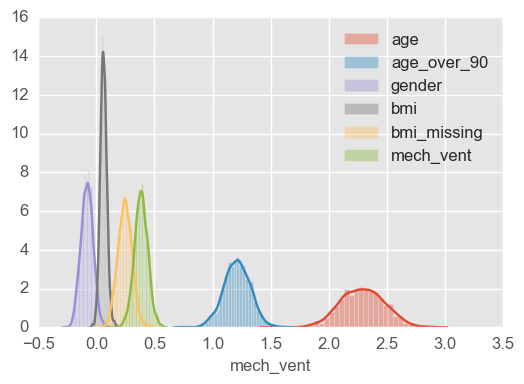

In [215]:
cols = covariates[:6]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,CHF,mdrd,creatinine_missing,apsiii,lactate,lactate_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.027772,0.114873,1.210258,0.756404,0.425651,0.073090
std,0.064734,0.027963,0.161537,0.033593,0.046386,0.058424
min,-0.198606,0.017742,0.668527,0.642097,0.282267,-0.092135
25%,-0.018022,0.095652,1.100441,0.734143,0.395242,0.034961
50%,0.027800,0.114680,1.208417,0.755415,0.425909,0.072586
75%,0.071290,0.134126,1.314417,0.778809,0.456948,0.109747
max,0.238998,0.208227,1.698486,0.870639,0.565443,0.269738


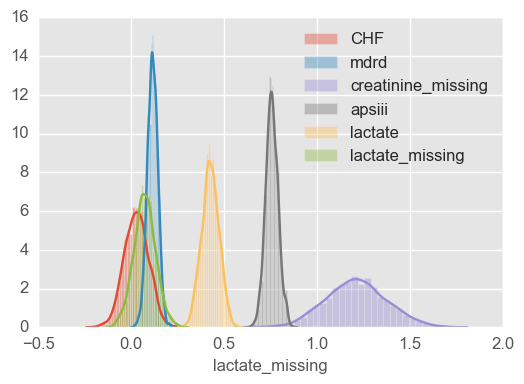

In [216]:
cols = covariates[6:12]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,sicu,nsicu,micu,on_vaso
count,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.007526,0.068574,0.271777,1.016855
std,0.060771,0.114049,0.083433,0.070838
min,-0.233362,-0.277970,0.029992,0.767290
25%,-0.048341,-0.003848,0.215865,0.972010
50%,-0.006644,0.068617,0.274543,1.016458
75%,0.034460,0.146038,0.327888,1.065288
max,0.195237,0.384991,0.543848,1.233069


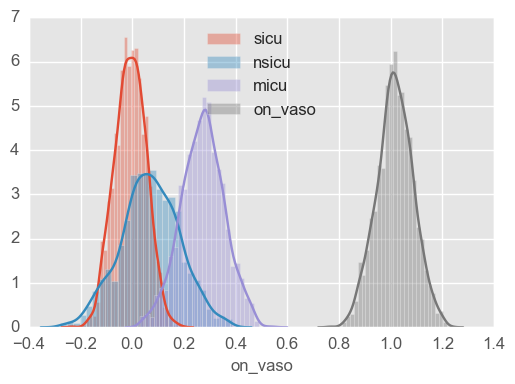

In [217]:
cols = covariates[12:]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,fluid_day2,fluid_day2_missing,lv_missing,lv_normal,lv_hyper,lv_mild,lv_moderate,lv_severe
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.067293,0.158361,0.011110,-0.058218,0.298434,-0.216300,-0.247858,-0.150007
std,0.044551,0.068180,0.152029,0.070556,0.138106,0.184487,0.319477,0.272552
min,-0.069015,-0.116398,-0.492309,-0.353962,-0.171813,-0.894781,-1.733955,-0.992374
25%,0.036252,0.112554,-0.087718,-0.106268,0.207174,-0.333388,-0.452990,-0.327104
50%,0.066800,0.157314,0.011831,-0.058161,0.295429,-0.213881,-0.247877,-0.145854
75%,0.098741,0.205600,0.115069,-0.010844,0.389351,-0.091890,-0.030761,0.024818
max,0.219049,0.434556,0.526462,0.206856,0.774029,0.386078,0.777838,0.705959


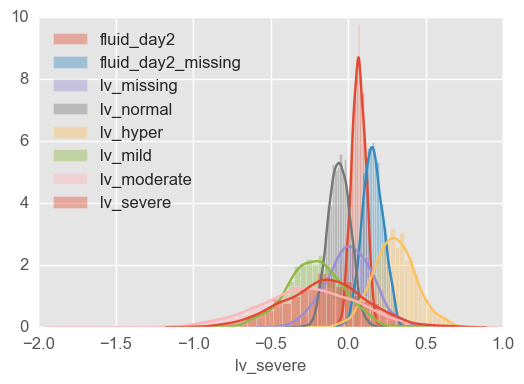

In [218]:
cols = fluid_features[fluid_fs] + echo_features[echo_fs]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,fluid_day2*lv_mild,fluid_day2*lv_missing,fluid_day2*lv_moderate,fluid_day2*lv_normal
count,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.655965,-0.206213,-0.134557,-0.203716
std,0.202083,0.111754,0.189299,0.066372
min,-1.331655,-0.708631,-0.757643,-0.429406
25%,-0.794731,-0.280704,-0.258815,-0.247968
50%,-0.648243,-0.203731,-0.140143,-0.203329
75%,-0.523786,-0.132737,-0.013180,-0.158477
max,0.047962,0.132106,0.655239,0.010850


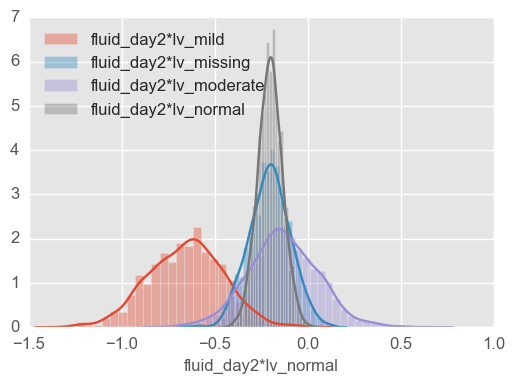

In [219]:
cols = [c for c in Xb.columns if 'fluid_day2*lv' in c]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,fluid_day2*CHF,lv_missing*CHF,lv_moderate*CHF,lv_severe*CHF
count,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.128626,0.240765,0.386419,0.186692
std,0.065287,0.215342,0.392300,0.315586
min,-0.100411,-0.409280,-1.004257,-0.740662
25%,0.084273,0.092672,0.126057,-0.022326
50%,0.130300,0.242494,0.399726,0.180575
75%,0.171765,0.385359,0.657093,0.391341
max,0.361635,0.954804,1.776907,1.102199


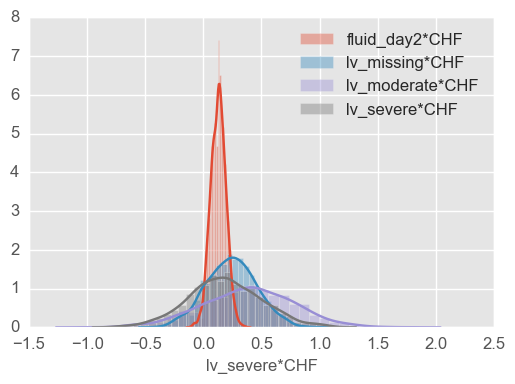

In [220]:
cols = [c for c in Xb.columns if '*CHF' in c]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')